Irrigation Sensor Data Analysis

There is something intriguing about sensor data from irrigation machines. The interplay between various sensor readings and parcel outputs raises questions about the correlations and hidden signals underlying these measurements. If you find this notebook useful, please upvote it.

In [1]:
# Imports and Setup
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # required for environments that need Agg backend
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # switch backend in case only plt is imported
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.inspection import permutation_importance

# Set Seaborn style for plots
sns.set(style='whitegrid')

# Set random seed for reproducibility
RANDOM_STATE = 42

In [2]:
# Load the irrigation machine dataset
data_path = 'data/irrigation_machine.csv'
df = pd.read_csv(data_path, encoding='ascii', delimiter=',')

# Display the first few rows of the dataframe
print('Data shape:', df.shape)
df.head()

Data shape: (2000, 24)


,Unnamed: 0,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,parcel_0,parcel_1,parcel_2
0,0,1.0,2.0,1.0,7.0,0.0,1.0,1.0,4.0,0.0,...,8.0,1.0,0.0,2.0,1.0,9.0,2.0,0,1,0
1,1,5.0,1.0,3.0,5.0,2.0,2.0,1.0,2.0,3.0,...,4.0,5.0,5.0,2.0,2.0,2.0,7.0,0,0,0
2,2,3.0,1.0,4.0,3.0,4.0,0.0,1.0,6.0,0.0,...,3.0,3.0,1.0,0.0,3.0,1.0,0.0,1,1,0
3,3,2.0,2.0,4.0,3.0,5.0,0.0,3.0,2.0,2.0,...,4.0,1.0,1.0,4.0,1.0,3.0,2.0,0,0,0
4,4,4.0,3.0,3.0,2.0,5.0,1.0,3.0,1.0,1.0,...,1.0,3.0,2.0,2.0,1.0,1.0,0.0,1,1,0


Data Cleaning and Preprocessing

In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print('Missing values in each column:\n', missing_values)

# The first column 'Unnamed: 0' is likely an index. We drop it if it does not bring informative content
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)
    print("Dropped 'Unnamed: 0' column as it is likely an index.")

# There are no explicit date columns provided. If in the future dates are provided, the following could help:
# df['date_column'] = pd.to_datetime(df['date_column'], format='%Y-%m-%d')

# Quick info about data types
print('\nData Types:')
print(df.dtypes)

Missing values in each column:
 Unnamed: 0    0
sensor_0      0
sensor_1      0
sensor_2      0
sensor_3      0
sensor_4      0
sensor_5      0
sensor_6      0
sensor_7      0
sensor_8      0
sensor_9      0
sensor_10     0
sensor_11     0
sensor_12     0
sensor_13     0
sensor_14     0
sensor_15     0
sensor_16     0
sensor_17     0
sensor_18     0
sensor_19     0
parcel_0      0
parcel_1      0
parcel_2      0
dtype: int64
Dropped 'Unnamed: 0' column as it is likely an index.

Data Types:
sensor_0     float64
sensor_1     float64
sensor_2     float64
sensor_3     float64
sensor_4     float64
sensor_5     float64
sensor_6     float64
sensor_7     float64
sensor_8     float64
sensor_9     float64
sensor_10    float64
sensor_11    float64
sensor_12    float64
sensor_13    float64
sensor_14    float64
sensor_15    float64
sensor_16    float64
sensor_17    float64
sensor_18    float64
sensor_19    float64
parcel_0       int64
parcel_1       int64
parcel_2       int64
dtype: object


Exploratory Data Analysis

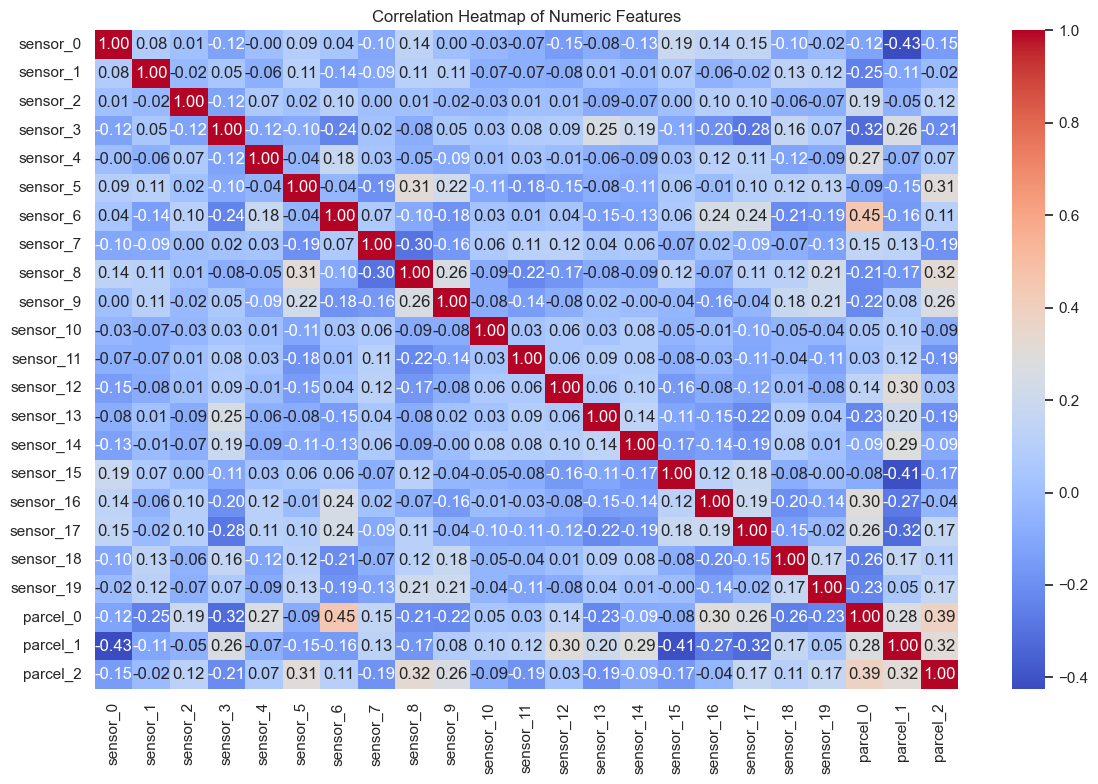

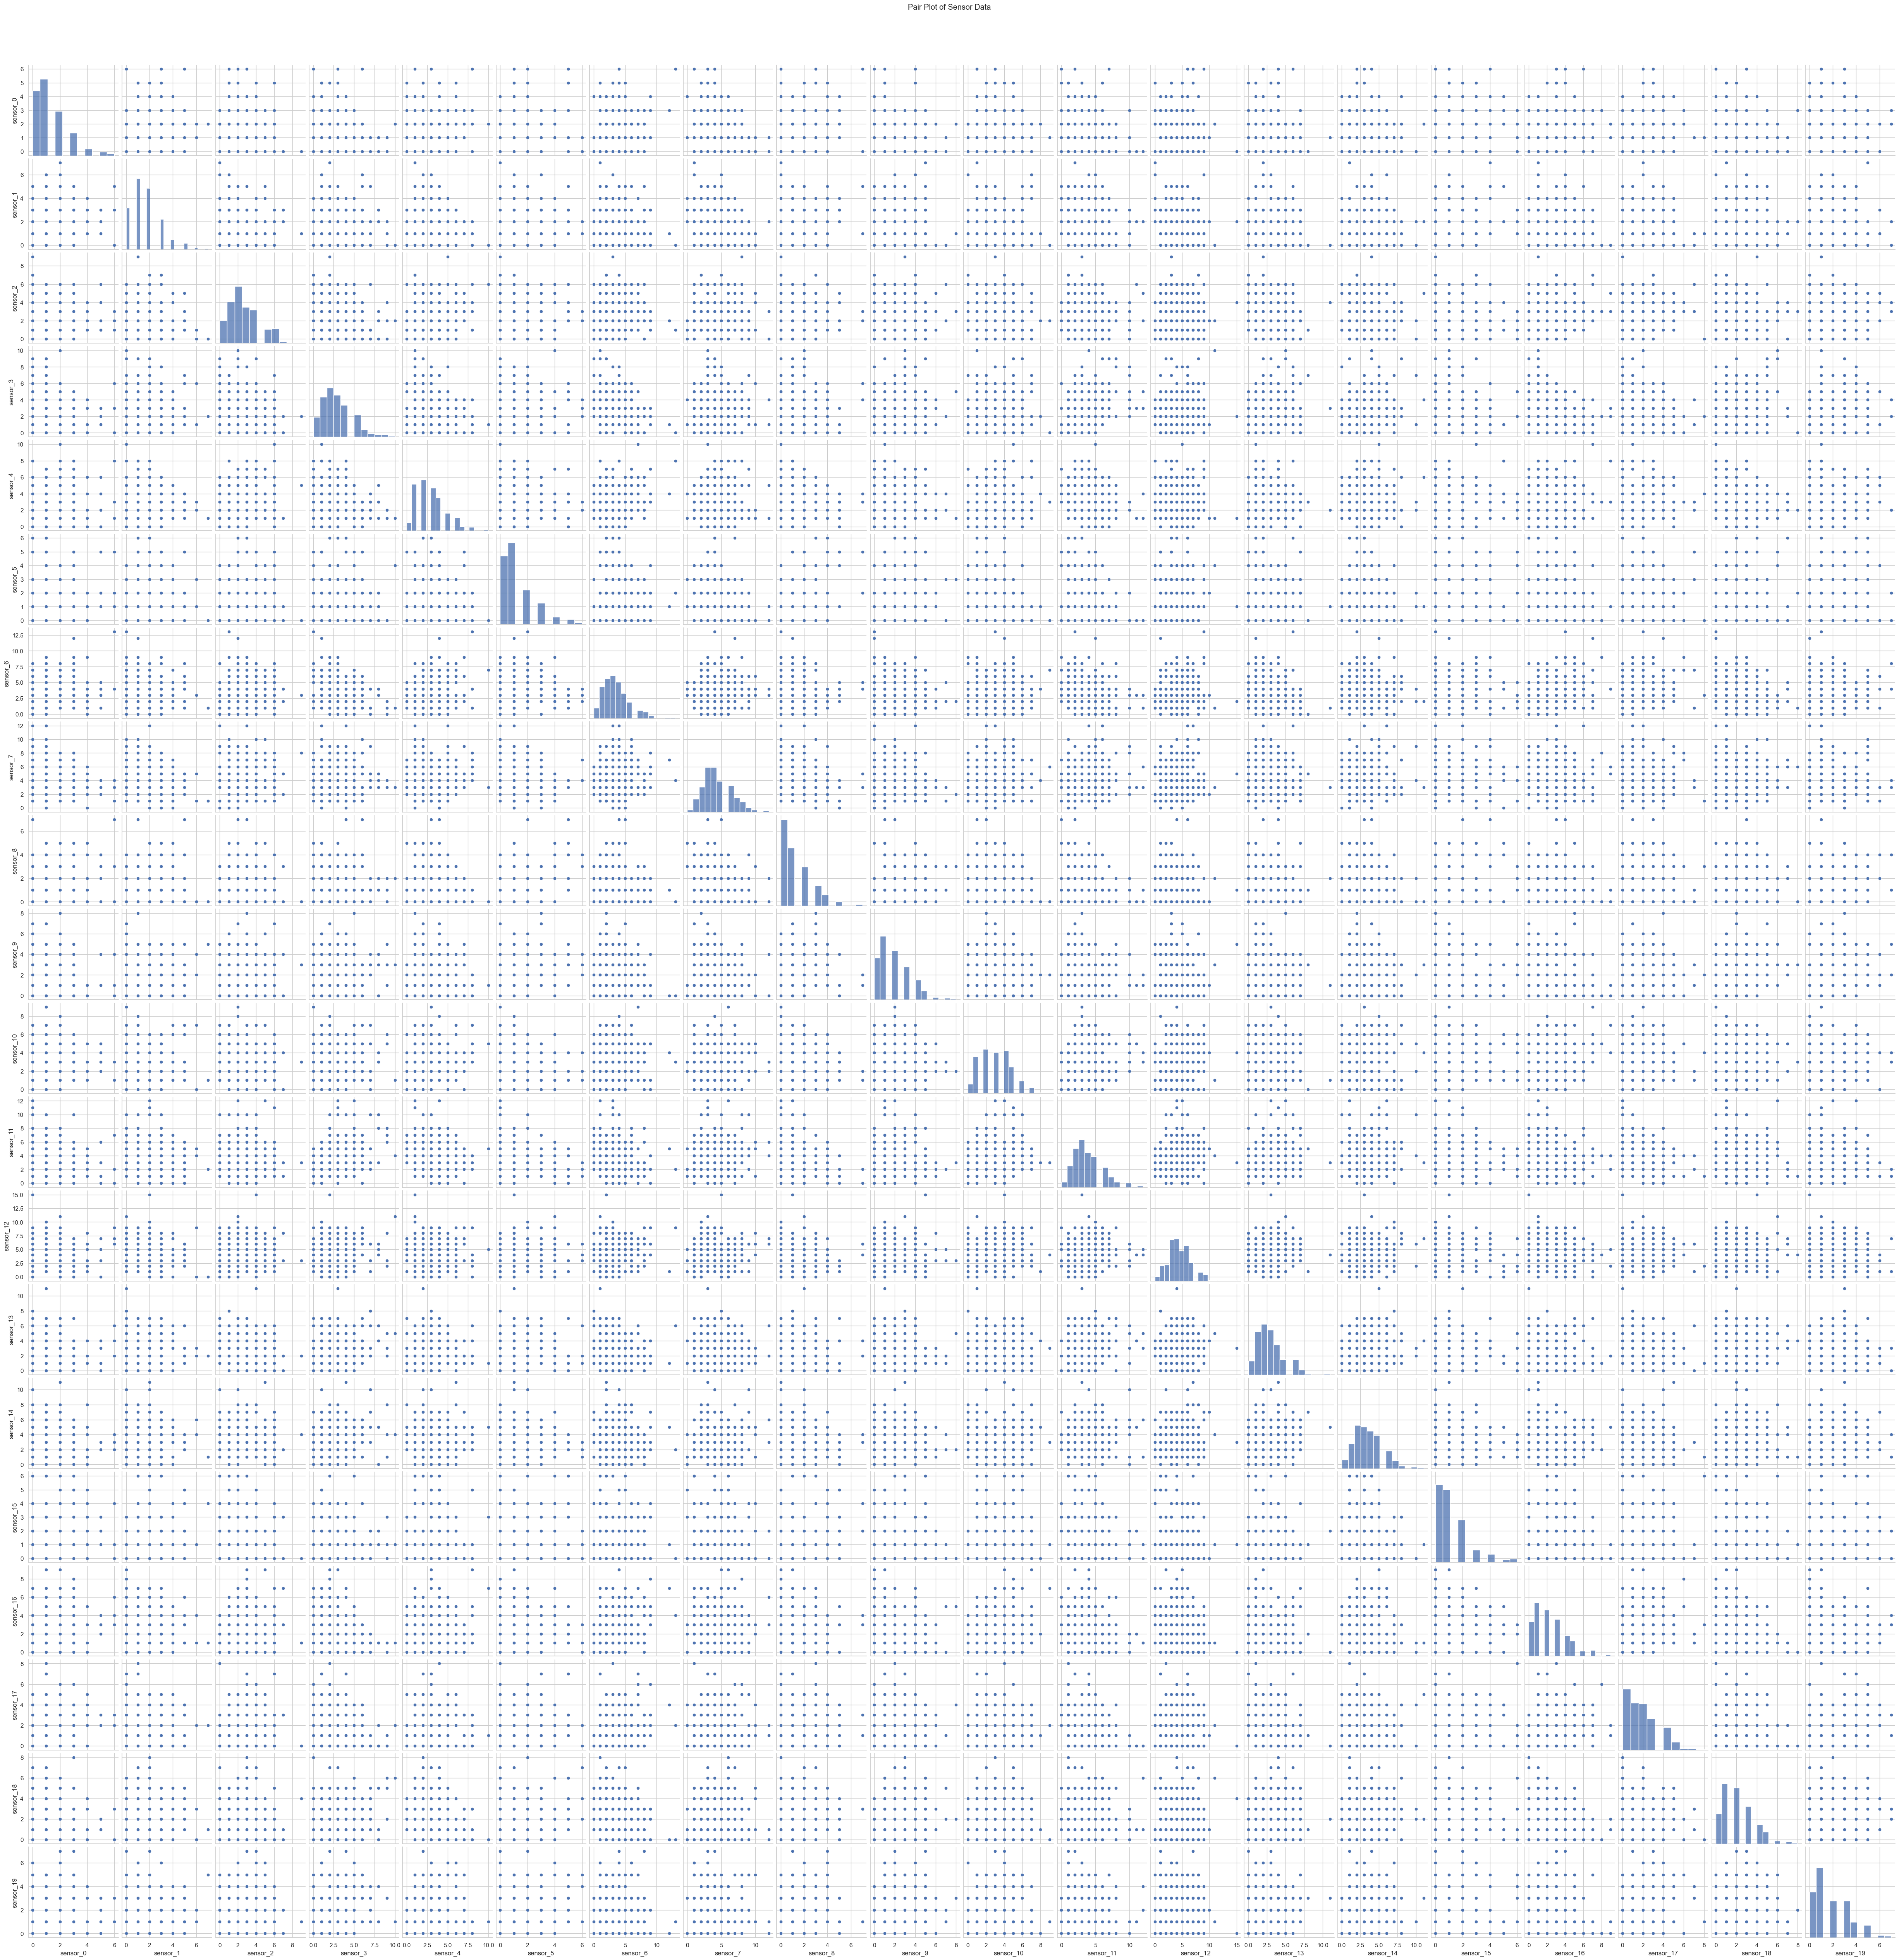

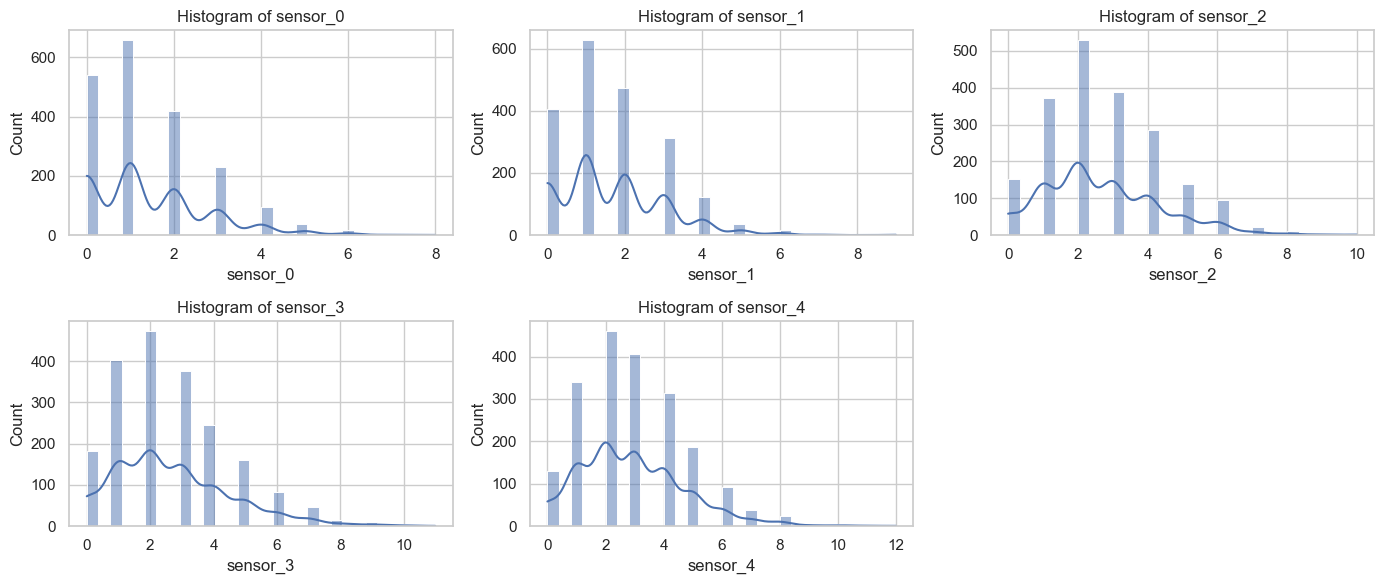

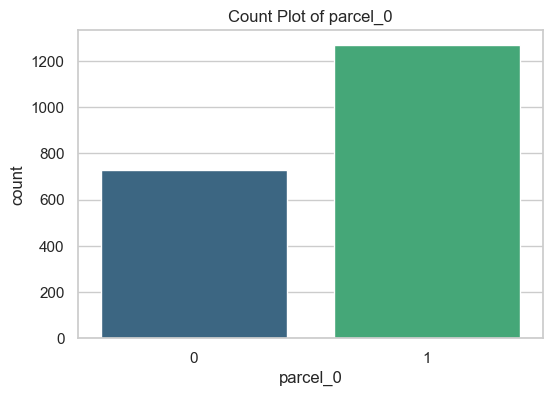

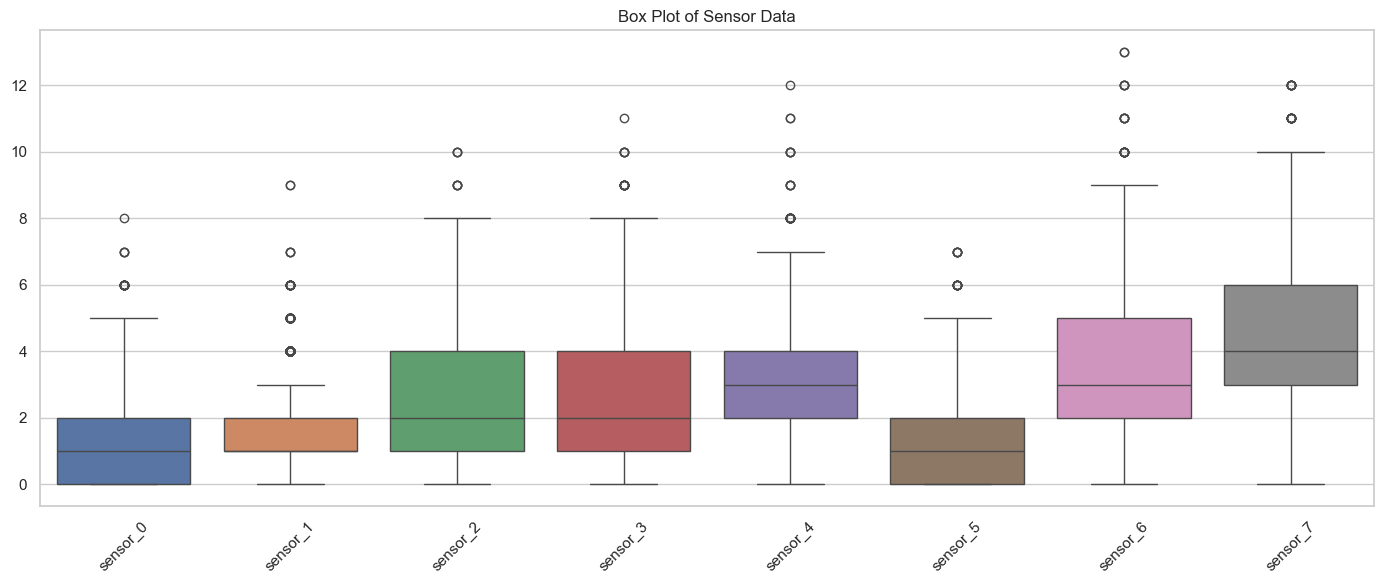

In [4]:
# Generate a correlation heatmap for numeric features (only if there are >= 4 numeric columns)
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(12, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a correlation heatmap.')

# Pair plot to observe pairwise relationships among sensor values
sensor_cols = [col for col in df.columns if col.startswith('sensor')]
if len(sensor_cols) > 1:
    sns.pairplot(df[sensor_cols].sample(min(300, len(df)), random_state=RANDOM_STATE))
    plt.suptitle('Pair Plot of Sensor Data', y=1.02)
    plt.show()
else:
    print('Not enough sensor data columns for a pair plot.')

    # Histograms for one or more sensor columns
plt.figure(figsize=(14, 6))
for i, col in enumerate(sensor_cols[:5]):  # limiting to first five sensor columns for clarity
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

# Pie chart (count plot) for one of the parcel columns if they represent categorical labels
parcel_cols = [col for col in df.columns if col.startswith('parcel')]
if parcel_cols:
    plt.figure(figsize=(6, 4))
    # Using countplot to show counts
    sns.countplot(data=df, x=parcel_cols[0], palette='viridis')
    plt.title(f'Count Plot of {parcel_cols[0]}')
    plt.show()
else:
    print('No parcel columns found to plot.')

# Box plots of sensor columns to inspect outliers
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[sensor_cols[:8]])  # plotting first eight sensor columns
plt.xticks(rotation=45)
plt.title('Box Plot of Sensor Data')
plt.tight_layout()
plt.show()

Predictive Modeling

Prediction Accuracy: 0.8675


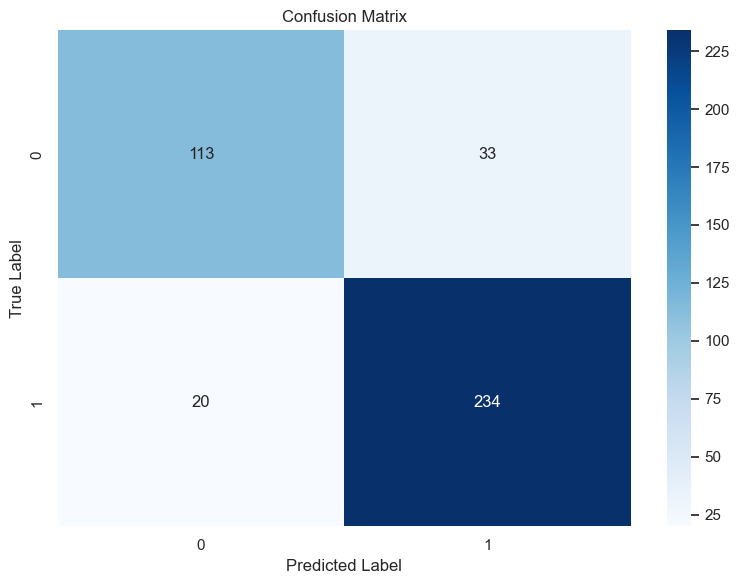

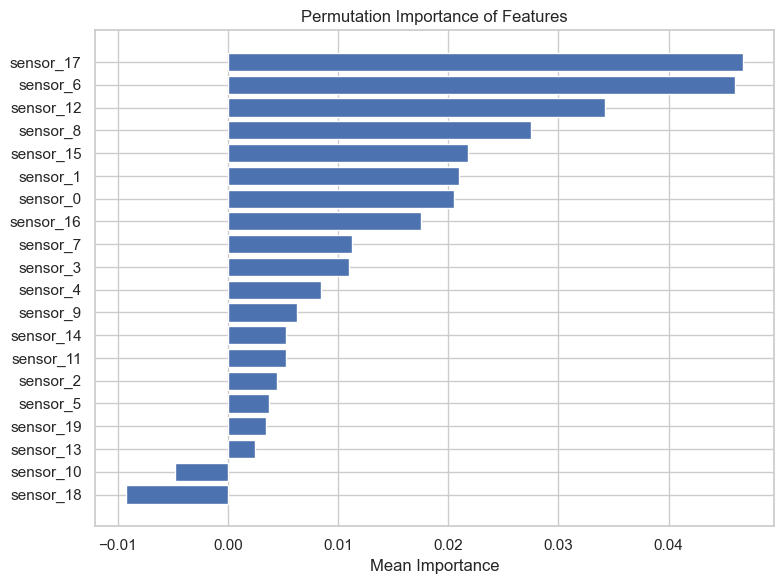

In [5]:
# For predictive modeling, we will treat one of the 'parcel' columns as the target variable.
# In this example, we choose 'parcel_0' as the target and use all sensor columns as predictors.

target_col = 'parcel_0'
if target_col not in df.columns:
    raise ValueError(f"Target column {target_col} not found in the dataframe.")

feature_cols = [col for col in df.columns if col.startswith('sensor')]
if len(feature_cols) == 0:
    raise ValueError('No sensor columns found in the dataframe to use as features.')

# Define X and y
X = df[feature_cols]
y = df[target_col]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Train a RandomForestClassifier. Note that if the target has more than two classes, ROC curves are not directly applicable.
clf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)
clf.fit(X_train, y_train)

# Predictor performance on test set
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Prediction Accuracy: {acc:.4f}')

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Permutation importance to identify influential features
perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE)
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(8, 6))
plt.barh(np.array(feature_cols)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title('Permutation Importance of Features')
plt.xlabel('Mean Importance')
plt.tight_layout()
plt.show()

Conclusion and Future Work

In this notebook, we loaded and preprocessed an irrigation machine sensor dataset and performed extensive exploratory analysis using several visualization techniques. We then built a RandomForest classifier to predict one of the parcel outputs based on the sensor readings. The model performed with a respectable prediction accuracy.